## 1. Load the paths to sequence files and annotation files

In [1]:
def transform_name(name, genome_files):
     if "Taraxacum" in name:
          name = "Taraxacum_kok-saghyz.genome.fasta.gz"
     elif "Aquilegia_coerulea" in name:
          name =  "Acoerulea_322_v3.fa.gz"
     elif "Ginkgo_biloba" in name:
          name =  "Gingko_biloba.1_0.fa.gz"
     elif "Cucurbita_maxima" in name:
          name =  "Cmaxima_genome_v1.1.fa.gz"
     elif "Cucurbita_pepo" in name:
          name =  "Cpepo_genome_v4.1.fa.gz"
     elif "Echinochloa_crus_galli" in name:
          name =  "Echinochloa_crus-galii.fasta.gz"
     elif "Cucurbita_moschata" in name:
          name =  "Cmoschata_genome_v1.fa.gz"
     elif "Solanum_lycopersicum" in name:
          name =  "S_lycopersicum_chromosomes.4.00.fa.gz"
     elif "Anthoceros_angustus" in name:
          name =  "Anthoceros.angustus.scaffold.fa.gz"
     elif "Musa_schizocarpa" in name:
          name = "Mschizocarpa_chromosomes.fa.gz"
     elif "Cuscuta_australis" in name:
          name = "Cuscuta.genome.v1.1.fa.gz"
     elif "Rubus_occidentalis" in name:
          name = "Rubus_occ_V3_10-12-17.fasta.gz"
     elif "Phyllostachys_edulis" in name:
          name = "Phyllostachys_heterocycla_v1.0.Scaffolds.gz"
     elif "Oryza_sativa_ssp._Indica" in name:
          name = "Oryza_sativa_indica_R498_Chr.fasta.gz"
     elif "Anthoceros_angustus" in name:
          name = "Anthoceros.angustus.scaffold.fa.gz"
     elif "Abies_alba" in name:
          name = "Abies_alba.1_1.fa.gz"
     else:
          pass
     for g in genome_files:
          if name in g:
               return g

In [2]:
from os import listdir
from os.path import isfile, join
genomes_path = "/mnt/extra/genomes/"
genomes_path2 = "/opt/genomes/"
annotation_path = "/opt/xhorvat9_TE_DBs/Genomes/Genomes/all_annotations/"
genome_files = [genomes_path + f for f in listdir(genomes_path) if isfile(join(genomes_path, f))] + [genomes_path2 + f for f in listdir(genomes_path2) if isfile(join(genomes_path2, f))]
annotation_files = [f for f in listdir(annotation_path) if isfile(join(annotation_path, f))]

def assign_annotation_file(genome_files, annotation_files):
    annot_dict = {}
    for a in annotation_files:
        name = a[:-4]
        # one exception
        annot_dict[name] = transform_name(name, genome_files)
    return annot_dict
annot_dict = assign_annotation_file(genome_files, annotation_files)

## 2. Extract LTR locations from annotation

In [ ]:
import tqdm
import pandas as pd
LTRs = {}
for species in annot_dict:
    if species not in ["Anthoceros_angustus", "Musa_schizocarpa", "Cuscuta_australis", "Rubus_occidentalis", "Phyllostachys_edulis", "Oryza_sativa_ssp._Indica", "Zostera_muelleri", "Volvox_carteri", "Pyrus_communis", "Nissolia_schottii", "Anthoceros_angustus", "Vigna_subterranea", "Begonia_fuchsioides", "Alnus_glutinosa", "Mimosa_pudica", "Abies_alba"]:
        continue
    if species != "Abies_alba":
        continue
    annot = pd.read_csv(f"{annotation_path}/{species}.txt", sep="\t", low_memory=False).iloc[:-1,]
    LTR_IDs = set(annot["LTR_ID"])
    print(f"Processing {species}")
    LTRs[species] = {}

    for idx in tqdm.tqdm(LTR_IDs):
        element = annot[annot["LTR_ID"] == idx]
        element_5LTR = element[element["Domain"] == "intact_5ltr"][["Start", "End"]]
        element_3LTR = element[element["Domain"] == "intact_3ltr"][["Start", "End"]]
        info = element[element["Domain"] == "intact_5ltr"][[ "Superfamily", "Lineages", "Divergence", "Chromosome"]]
        try:
            superfamily = info.iloc[0, 0]
            lineage = info.iloc[0, 1]
            divergence = info.iloc[0, 2]
            chromosome = info.iloc[0, 3]

            LTRs[species][idx] = ({"Start": int(element_5LTR["Start"].iloc[0]),"End": int(element_5LTR["End"].iloc[0])}, # 5' LTR position
                                  {"Start": int(element_3LTR["Start"].iloc[0]),"End": int(element_3LTR["End"].iloc[0])}, # 3' LTR position
                                  superfamily,                                                                           # superfamily   
                                    lineage,                                                                             # lineage
                                    divergence,                                                                          # divergence of LTR sequences
                                    chromosome)                                                                          
        except:
            pass

In [10]:
import json

with open('LTR_locations_extra.txt', 'w') as convert_file:
     convert_file.write(json.dumps(LTRs))

In [3]:
import json
  
# If ltr locations are already saved
with open('LTR_locations_extra.txt', "r") as f:
    LTRs = json.load(f)

## 3. Extract LTRs using annotations

In [18]:
from joblib import Parallel, delayed
import Bio.SeqIO as SeqIO
import gzip
from Bio.SeqRecord import SeqRecord
import tqdm
import pandas as pd

def transform_chromosome(fasta_file, chromosome):
    """
    Transforms chromosome names to match the names in the fasta file
    """
    if "Betula_pendula" in fasta_file:
        s = chromosome.split("|")
        out_chr = "|".join([s[0], s[1], s[1] + ".1"])
        return out_chr
    elif "Catharanthus_roseus" in fasta_file:
        return "cro_v2_" + chromosome
    elif "Volvox_carteri" in fasta_file:
        out_chr = chromosome[5:]
        return "ENA|" + out_chr + "|" + out_chr + ".1"
    elif "Pogostemon_cablin" in fasta_file or "Chondrus_crispus" in fasta_file:
        k = chromosome.split("|")
        return "ENA|" + k[1] + "|" + k[1] + ".1"
    elif "Cercis_canadensis" in fasta_file or \
        "Fagus_sylvatica" in fasta_file or \
        "Glycine_max" in fasta_file or \
        "Gossypium_raimondii" in fasta_file or \
        "Gossypium_hirsutum" in fasta_file or \
        "Gossypium_arboreum" in fasta_file or \
        "Faidherbia_albida" in fasta_file or \
        "Moringa_oleifera" in fasta_file or \
        "Lablab_purpureus" in fasta_file or \
        "Pyrus_communis" in fasta_file or \
        "Chamaecrista_fasciculata" in fasta_file or \
        "Alnus_glutinosa" in fasta_file or \
        "Mimosa_pudica" in fasta_file or \
        "Sclerocarya_birrea" in fasta_file or \
        "Begonia_fuchsioides" in fasta_file or \
        "Vigna_subterranea" in fasta_file or \
        "Anthoceros_angustus" in fasta_file or \
        "Nissolia_schottii" in fasta_file or \
        "Pyrus_communis" in fasta_file:
        out_chr = chromosome[3:]
        return "scaffold" + out_chr
    elif "Chrysanthemum_nankingense" in fasta_file:
        s = chromosome.split("_")[0]
        return s + "_pilon_pilon"
    elif "Sisymbrium_irio" in fasta_file or "Utricularia_gibba" in fasta_file:
        return "lcl|" + chromosome
    elif "Erigeron_breviscapus" in fasta_file:
        return "opera_" + chromosome
    elif "Triticum_aestivum" in fasta_file:
        return chromosome[3:]
    elif "Cicer_arietinum" in fasta_file:
        return "cicar.CDCFrontier.gnm3.chr" + chromosome[2:]
    elif "Zostera_muelleri" in fasta_file:   
        return "_".join(chromosome.split("_")[3:])
    else:
        return chromosome
        raise KeyError("Chromosome not found")
    
    
def extract_LTR(fasta_file, LTRs, genomes_path):
    print(f"processing {fasta_file}")
    with gzip.open(f"{fasta_file}", "rt") as handle:
        records = {(rec.id): rec.seq for rec in SeqIO.parse(handle, "fasta")}    
    out_sequences = []
    print(records.keys())
 
    for idx in LTRs:
        try:
            chromosome = LTRs[idx][5]
            chromosome = transform_chromosome(fasta_file, chromosome)
            
            start5 = LTRs[idx][0]["Start"]
            end5 = LTRs[idx][0]["End"]
            
            seq5 = records[chromosome][start5:end5]

            start3 = LTRs[idx][1]["Start"]
            end3 = LTRs[idx][1]["End"]

            seq3 = records[chromosome][start3:end3]

            rec_description = " " + str(LTRs[idx][2]) + " " + str(LTRs[idx][3]) + " " + str(LTRs[idx][4])

            
            LTR5 = SeqRecord(seq=seq5, id=idx + "_ltr5", description=rec_description)
            LTR3 = SeqRecord(seq=seq3, id=idx + "_ltr3", description=rec_description)
            out_sequences.append(LTR5)
            out_sequences.append(LTR3)   
        except KeyError as e:
            print(e)
        except TypeError as e:
            print(e)

    if len(out_sequences) != 0:
        n = fasta_file[:-3]
        n = n.split("genomes/")[1]
        with open(f"LTRs_{n}", "w+") as outfile:
            SeqIO.write(out_sequences, outfile, "fasta")
    else: 
        print(f"failed to find corresponding LTR sequences for {fasta_file}")

results = Parallel(n_jobs=5)(delayed(extract_LTR)(annot_dict[species], LTRs[species], genomes_path) for species in tqdm.tqdm(LTRs))


100%|██████████| 1/1 [00:00<00:00, 1064.00it/s]


In [12]:
from os import listdir
from os.path import isfile, join
LTR_files = [f[5:] for f in listdir("/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs") if isfile(join("/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs", f))]
gf = [f for f in listdir(genomes_path) if isfile(join(genomes_path, f))] + [f for f in listdir(genomes_path2) if isfile(join(genomes_path2, f))]
missing = [g for g in gf if not any([LTR_file in g for LTR_file in LTR_files])]
print(missing)

['Nissolia_schottii_v1.fa.gz', 'Citrus_clementina_v1.0.genome.fa.gz', 'Paab.1_0b.fa.gz', 'Mschizocarpa_chromosomes.fa.gz', 'Cuscuta.genome.v1.1.fa.gz', 'Quercus_lobata.fa.gz', 'Populus_tremula_genome.fasta.gz', 'Eragrostis_tef_tef.fa.gz', 'Rubus_occ_V3_10-12-17.fasta.gz', 'Phyllostachys_heterocycla_v1.0.Scaffolds.gz', 'Oryza_sativa_indica_R498_Chr.fasta.gz', 'Prunus_avium_v1.0.a1_pseudomolecule.fasta.gz', 'Mumian.Scaffold.fa.gz', 'Coffea_arabica.assembly.fa.gz', 'Solanum_chaocense_v4.1_PM_plus_chrUn.fa.gz', 'Pyrus_communis_v1.0-scaffolds.fna.gz', 'Arachis_monticola_all_genome_v1.2.fasta.gz', 'Vigna_radiata.VC1973A.gnm7.SB53.genome_main.fa.gz', 'Volvox_carteri.fa.gz', 'Zostera_muelleri_v1_scaffolds.fa.gz', 'Abies_alba.1_1.fa.gz', 'Rosa_chinensis_OBDH_1.0_formated.fasta.gz', 'Lupinus_angustifolius_gene_v2.0.fa.gz', 'Annuum.v1.6.Total.fa.gz', 'Pagl.1_0.fa.gz', 'Camptotheca_acuminata_genome_assembly_v2.4.fa.gz', 'Cuscuta_campestris_0.32.assembly.dna.fasta.gz', 'Saccharum_spp_R570_assembly.

In [20]:
LTR_files = [f[5:] for f in listdir("/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs") if isfile(join("/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs", f)) ]

## Align LTR pairs to each other to verify annotation

In [ ]:
from Bio import Align
import tqdm
import Bio.SeqIO as SeqIO
aligner = Align.PairwiseAligner()
aligner.mode = 'local'

seq_dict = {}
for f in tqdm.tqdm(LTR_files):
    seq_dict[f] = {}
    ltr5 = None
    ltr3 = None
    for rec in SeqIO.parse(f"/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs/LTRs_{f}", "fasta"):
        if ltr5 is None:
            ltr5 = rec
        else:
            ltr3 = rec
            idx = "_".join(rec.id.split("_")[:-1])
            # align sequences
            try:
                alignments = aligner.align(str(ltr5.seq),str(ltr3.seq))
                alignment = alignments[0]
                seq_dict[f][idx] = (alignment.score/min(len(ltr3.seq),len(ltr5.seq)), ltr5.description.split()[-1])
                
                
            except IndexError:
                #print("No optimal alignment for", f, idx)
                seq_dict[f][idx] = (0, ltr5.description.split()[-1])
                
            except ValueError:
                print("Zero length sequence", f, idx)
            # reset sequences
            ltr5 = None
            ltr3 = None


In [24]:
import json

with open('alignments.txt', 'w') as convert_file:
     convert_file.write(json.dumps(seq_dict))

In [1]:
import json

# Opening JSON file
with open('alignments.txt', "r") as f:
    seq_dict = json.load(f)

In [ ]:
import seaborn as sns
from statistics import mean
import pandas as pd
avg_identities = {species : mean(seq_dict[species][idx][0]for idx in seq_dict[species]) for species in seq_dict}
df = pd.DataFrame({"name":list(avg_identities.keys()), "mean identity": list(avg_identities.values())})
sns.set(rc={"figure.figsize":(18, 10)})
g = sns.barplot(x = "name", y="mean identity", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation = 90)

# Filter sequences
 if sequence has 0 length or low identity, remove it
 
Also remove Citrus sinensis, Musa acuminata and Cucumis melo altogether

In [5]:
from os import listdir
from os.path import isfile, join
genomes_path = "/mnt/extra/genomes/"
genomes_path2 = "/opt/genomes/"
annotation_path = "/opt/xhorvat9_TE_DBs/Genomes/Genomes/all_annotations/"
genome_files = [genomes_path + f for f in listdir(genomes_path) if isfile(join(genomes_path, f))] + [genomes_path2 + f for f in listdir(genomes_path2) if isfile(join(genomes_path2, f))]
annotation_files = [f for f in listdir(annotation_path) if isfile(join(annotation_path, f))]

def assign_annotation_file(genome_files, annotation_files):
    annot_dict = {}
    for a in annotation_files:
        name = a[:-4]
        # one exception
        if "Taraxacum" in name:
            annot_dict[name] = "Taraxacum_kok-saghyz.genome.fasta.gz"
        else:
            for g in genome_files:
                if name in g:
                    annot_dict[name] = g
    return annot_dict
annot_dict = assign_annotation_file(genome_files, annotation_files)

In [6]:
from os import listdir
from os.path import isfile, join
LTR_files = [f[5:] for f in listdir("/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs") if isfile(join("/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs", f))]
gf = [f for f in listdir(genomes_path) if isfile(join(genomes_path, f))] + [f for f in listdir(genomes_path2) if isfile(join(genomes_path2, f))]
missing = [g for g in gf if not any([LTR_file in g for LTR_file in LTR_files])]
print(missing)

['Citrus_clementina_v1.0.genome.fa.gz', 'Paab.1_0b.fa.gz', 'Quercus_lobata.fa.gz', 'Populus_tremula_genome.fasta.gz', 'Eragrostis_tef_tef.fa.gz', 'Prunus_avium_v1.0.a1_pseudomolecule.fasta.gz', 'Mumian.Scaffold.fa.gz', 'Coffea_arabica.assembly.fa.gz', 'Solanum_chaocense_v4.1_PM_plus_chrUn.fa.gz', 'Pyrus_communis_v1.0-scaffolds.fna.gz', 'Arachis_monticola_all_genome_v1.2.fasta.gz', 'Vigna_radiata.VC1973A.gnm7.SB53.genome_main.fa.gz', 'Zostera_muelleri_v1_scaffolds.fa.gz', 'Rosa_chinensis_OBDH_1.0_formated.fasta.gz', 'Lupinus_angustifolius_gene_v2.0.fa.gz', 'Annuum.v1.6.Total.fa.gz', 'Pagl.1_0.fa.gz', 'Camptotheca_acuminata_genome_assembly_v2.4.fa.gz', 'Cuscuta_campestris_0.32.assembly.dna.fasta.gz', 'Saccharum_spp_R570_assembly.fna.gz', 'Actinidia_chinensis_Hongyang_genome_v3.0_update.fa.gz', 'Salvia_splendens_genome.fasta.gz', 'Malania_oleifera_genome.fa.gz', 'Oryza_glaberrima_V1.dna_sm.toplevel.fa.gz', 'Arachis_ipaensis_K30076.gnm2.1GWY.genome_main.fa.gz', 'Discaria_trinervis_v1.0.fa.

In [12]:
import json
  
# Opening JSON file
with open('alignments.txt', "r") as f:
    seq_dict = json.load(f)

In [7]:
import Bio.SeqIO as SeqIO
import numpy as np
import tqdm
# match sequences, their ID, family, lineage and identity in a pandas Dataframe
seq_info = []
alignment_info = []
for LTR_file in tqdm.tqdm(LTR_files):
    for rec in SeqIO.parse(f"/home/xhorvat9/ltr_bert/DatabaseGeneration/PositiveDB/LTRs/LTRs_{LTR_file}", "fasta"):
        if "ltr5" in rec.id:
            type = "ltr5"
        else:
            type = "ltr3"
        _, superfamily, lineage, _ = rec.description.split()
        seq_info.append([LTR_file, rec.seq, rec.id[:-5], type, superfamily, lineage])
    for seq_id in seq_dict[LTR_file]:
        alignment_info.append([seq_id, seq_dict[LTR_file][seq_id][0]])


100%|██████████| 80/80 [00:11<00:00,  7.06it/s]


In [8]:
seq_info = np.array(seq_info)

/home/xhorvat9/miniconda3/envs/dnabert/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [9]:
alignment_info = np.array(alignment_info)

In [10]:
import pandas as pd
LTRs_df = pd.DataFrame({"Species":seq_info[:, 0], "Sequence": seq_info[:, 1], "ID":seq_info[:, 2], "LTR_type": seq_info[:, 3], "Superfamily":seq_info[:, 4], "Lineage": seq_info[:, 5]})
alignment = pd.DataFrame({"ID": alignment_info[:, 0], "LTR_identity": alignment_info[:, 1]})
LTRs_df = LTRs_df.set_index("ID")
alignment = alignment.set_index("ID")
LTRs_df = LTRs_df.join(alignment)

In [11]:
LTRs_df["Sequence"] = LTRs_df["Sequence"].apply(lambda sequence: str(sequence))

In [27]:
list(df[df["mean identity"] < 0.8].name)

['Citrus_sinensis_v2.0.genome.fa',
 'Cicer_arietinum_CDCFrontier.gnm3.QT0P.genome_main.fa',
 'Musa_acuminata_pahang_v4.fa',
 'Echinochloa_crus-galii.fasta',
 'Cucumis_melo_genome_pseudomolecules_V3.5.fasta']

In [41]:
LTRs_df = LTRs_df[~LTRs_df['Species'].isin(list(df[df["mean identity"] < 0.8].name))]
LTRs_df = LTRs_df[LTRs_df["LTR_type"].str.contains("ltr5")]
LTRs_df = LTRs_df[LTRs_df["Sequence"].apply(lambda x: len(x)) > 10]
LTRs_df["LTR_identity"] = LTRs_df["LTR_identity"].astype(float)
LTRs_df = LTRs_df[LTRs_df["LTR_identity"] > 0.7]
LTRs_df

,Species,Sequence,LTR_type,Superfamily,Lineage,LTR_identity
ID,,,,,,
0015.scaffold00050_178341_185724,Beta_vulgaris_v1.2.fa,GGAGTAGGGAGCAAAGATGTAATACTCCGTATTTTTGGAGTTAATT...,ltr5,gypsy,Tekay,0.945000
0015.scaffold00050_254985_260326,Beta_vulgaris_v1.2.fa,GTAGGATATTTTGGAGTAATACTGTGGAAAGATTAACAACAAATAA...,ltr5,copia,Alesia,0.984615
0018.scaffold00058_171143_176132,Beta_vulgaris_v1.2.fa,TACAAAAATATCTCTAACTACAATCTTATCTTTATCAATACATGAA...,ltr5,copia,Ale,0.941748
0019.scaffold00065_36156_46000,Beta_vulgaris_v1.2.fa,TACGCAACGACGCGATGATTCAATGACATGATGCCATCTGACATGA...,ltr5,gypsy,Retand,0.975083
0020.scaffold00069_399781_404982,Beta_vulgaris_v1.2.fa,CAATGTGTAGAAATATGCCTTGAATCATTGTGCATCGAAGGTGTTC...,ltr5,copia,Tork,0.990893
...,...,...,...,...,...,...
utg99796_39991_51594,Chrysanthemum_nankingense_scaffolds_v2.0.fasta,AACCATCTAGCGTAATTTTAGGCTAAATATCCAAAGATAACCTTAG...,ltr5,copia,Ale,0.941176
utg997_59646_65214,Chrysanthemum_nankingense_scaffolds_v2.0.fasta,CTGTTATGACTGCTTTATGACCACGTTTAATTGGTCATGTAACCAC...,ltr5,copia,TAR,0.973529
utg998_36947_41877,Chrysanthemum_nankingense_scaffolds_v2.0.fasta,GTTGGGCTAATGACTGACCCGAGCTTATGGGGCAGTAGCCATCTAC...,ltr5,copia,Ivana,1.000000


In [43]:
LTRs_df.to_csv("LTRs.csv")

<AxesSubplot:xlabel='LTR_identity', ylabel='Count'>

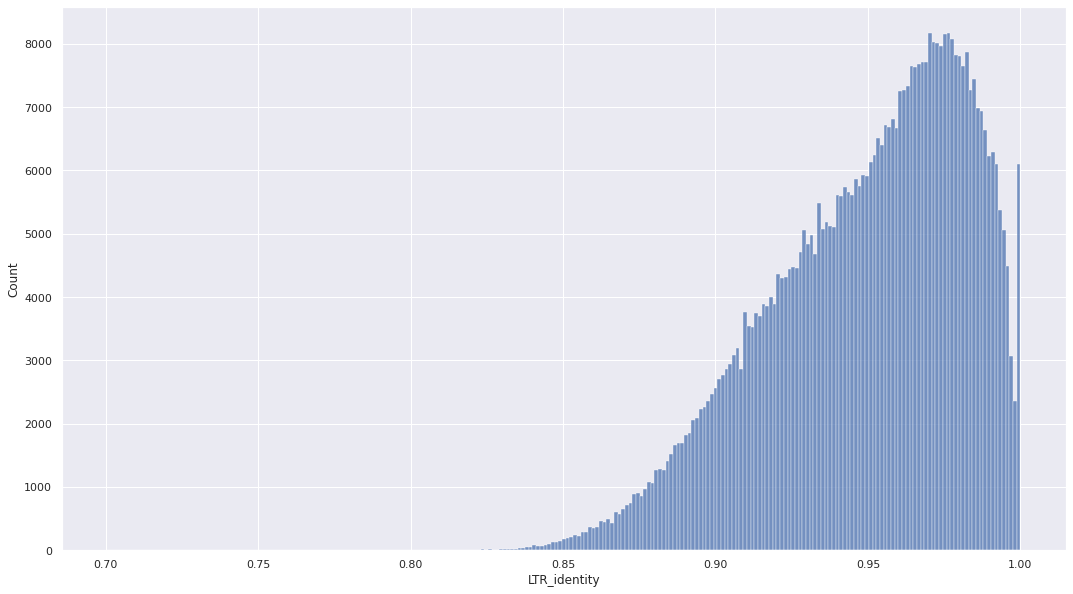

In [42]:
sns.histplot(LTRs_df["LTR_identity"])

In [44]:
LTRs_df["ID"] = LTRs_df.index

In [82]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
def row_to_record(row):
    LTR_type = row["LTR_type"]
    Superfamily = row["Superfamily"]
    Lineage = row["Lineage"]
    Species = row["Species"]
    seq_record = SeqRecord(seq=Seq(row["Sequence"]), id=row["ID"], description=f'{Species} {LTR_type} {Superfamily} {Lineage}')
    return seq_record

seq_records = [row_to_record(row) for _, row in LTRs_df.iterrows()]

import Bio.SeqIO as SeqIO
SeqIO.write(seq_records, open("filtered_sequences.fasta", "w+"), "fasta")

509739

In [75]:
LTRs_df = pd.read_csv("LTRs.csv")

In [68]:
LTRs_df["Lineage"].value_counts()[:23]

Angela         86565
Tekay          67472
CRM            66023
Athila         51278
Retand         47822
SIRE           37100
Ale            35106
Tork           23777
TatII          17701
TAR            10939
Ivana          10880
copia          10065
Reina           9947
Ikeros          9214
Gymco-II        5135
Bianca          4178
TatIII          4010
Ogre            3416
Galadriel       2188
NAN             1314
Gymco-IV        1302
chromovirus      750
Alesia           515
Name: Lineage, dtype: int64

In [76]:
def convert_lineage_name(lineage_names, name):
    current_lineage = ""
    for l in lineage_names:
        if l.lower() in name.lower():
            if len(current_lineage) < len(l):
                current_lineage = l
    if current_lineage == "":
        return name
    return current_lineage

lin_names = list(LTRs_df["Lineage"].value_counts()[:23].index)
LTRs_df["Lineage"] = LTRs_df["Lineage"].apply(lambda x: convert_lineage_name(lin_names, x))

Text(0.5, 1.0, 'LTRs with identity < 80%')

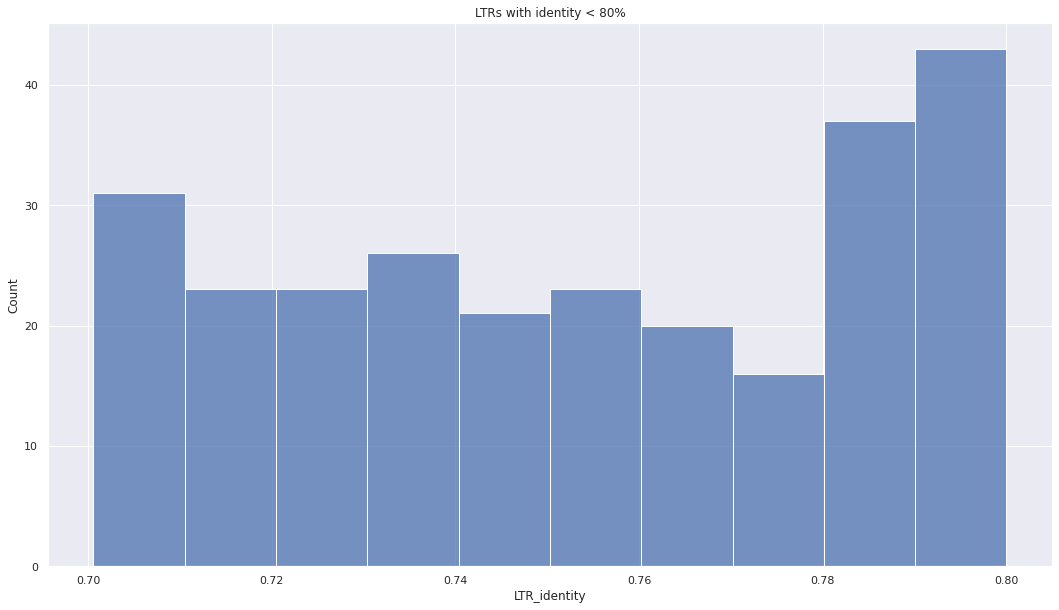

In [78]:
import seaborn as sns
sns.histplot(data=LTRs_df[LTRs_df["LTR_identity"] <= 0.8]["LTR_identity"]).set_title("LTRs with identity < 80%") 

Text(0.5, 1.0, 'LTRs with identity > 80%')

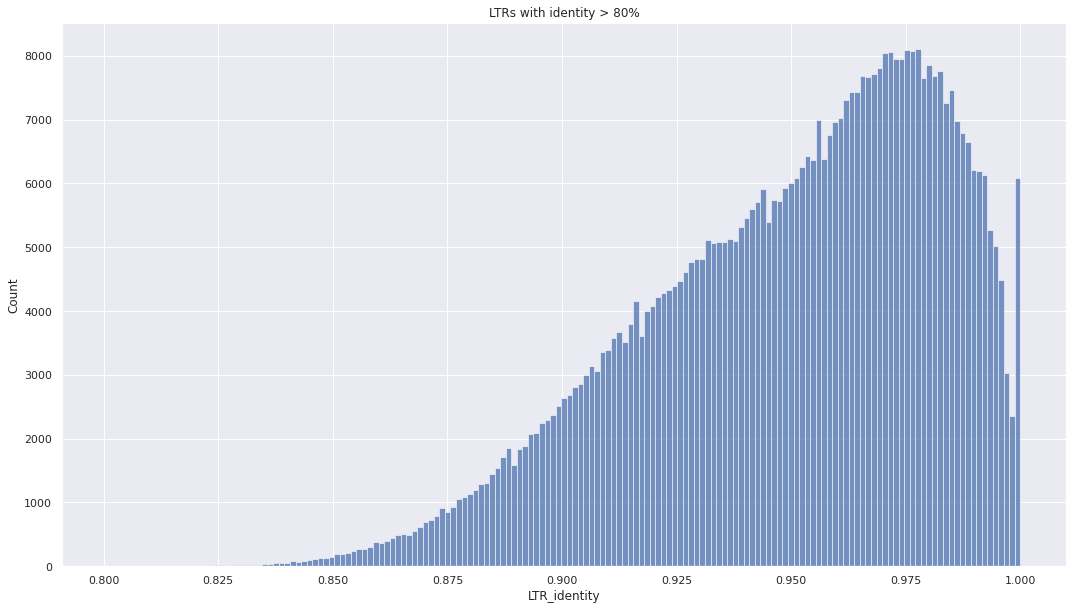

In [79]:
sns.histplot(data=LTRs_df[LTRs_df["LTR_identity"] > 0.8]["LTR_identity"]).set_title("LTRs with identity > 80%") 

Text(0.5, 1.0, 'LTR sequence length')

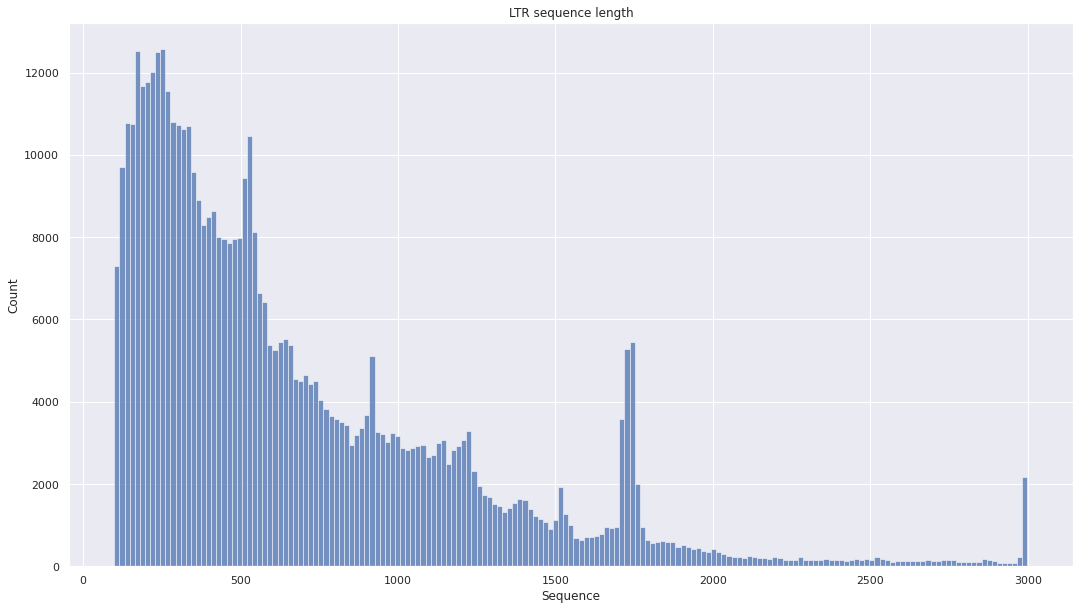

In [80]:
length = LTRs_df["Sequence"].apply(lambda x: len(x))
sns.histplot(length).set_title("LTR sequence length")

/home/xhorvat9/miniconda3/envs/dnabert/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Tekay'),
 Text(1, 0, 'Alesia'),
 Text(2, 0, 'Ale'),
 Text(3, 0, 'Retand'),
 Text(4, 0, 'Tork'),
 Text(5, 0, 'Ivana'),
 Text(6, 0, 'TAR'),
 Text(7, 0, 'CRM'),
 Text(8, 0, 'Athila'),
 Text(9, 0, 'Angela'),
 Text(10, 0, 'Reina'),
 Text(11, 0, 'SIRE'),
 Text(12, 0, 'Bianca'),
 Text(13, 0, 'Ikeros'),
 Text(14, 0, 'Ogre'),
 Text(15, 0, 'Galadriel'),
 Text(16, 0, 'NAN'),
 Text(17, 0, 'TatII'),
 Text(18, 0, 'copia'),
 Text(19, 0, 'Chlamyvir'),
 Text(20, 0, 'Osser'),
 Text(21, 0, 'chromo-unclass'),
 Text(22, 0, 'TatIII'),
 Text(23, 0, 'Gymco-II'),
 Text(24, 0, 'chromovirus'),
 Text(25, 0, 'Gymco-IV'),
 Text(26, 0, 'Gymco-I'),
 Text(27, 0, 'OTA'),
 Text(28, 0, 'Tat')]

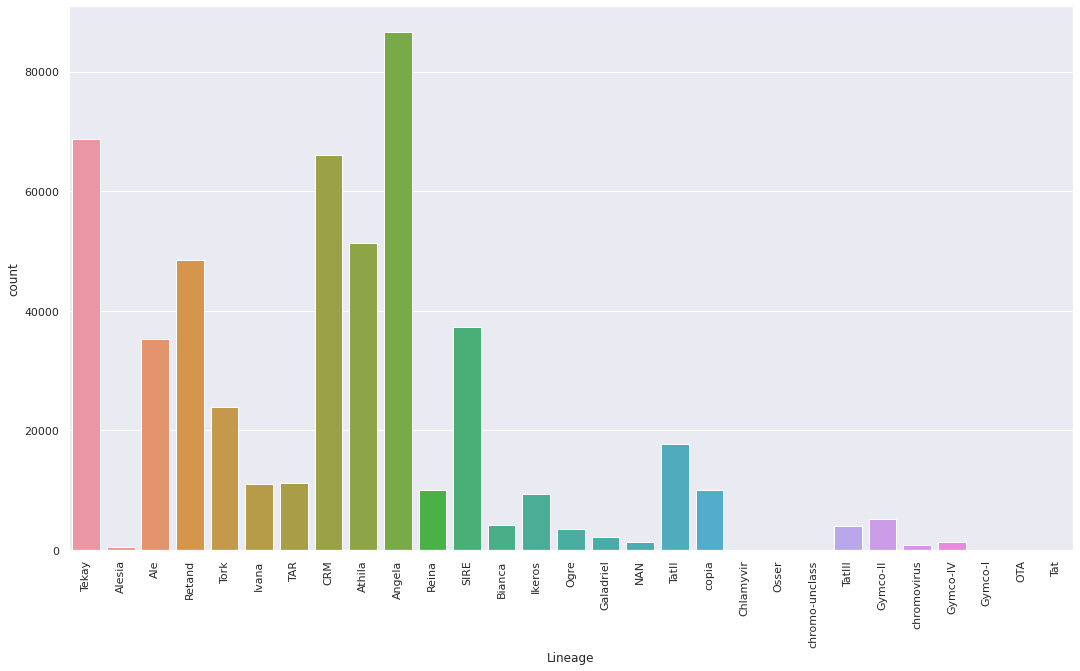

In [81]:
g = sns.countplot(LTRs_df["Lineage"])
g.set_xticklabels(g.get_xticklabels(),rotation = 90)

In [ ]:
from scipy.stats import ranksums

rejected = 0
accepted = 0
total_seq_count = 0
for species in seq_dict:
    alignment_identity = [seq_dict[species][ltr][0] for ltr in seq_dict[species]]
    divergence = [seq_dict[species][ltr][1] for ltr in seq_dict[species]]
    res = ranksums(alignment_identity, divergence)
    print(f"Means for {species} are identical:", res[1]>0.05)
    if res[1]>0.05:
        accepted += 1
    else:
        rejected += 1
    total_seq_count += len(alignment_identity)

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot([seq_dict["LTRs_Fagopyrum_esculentum_r1.0.fa"][ltr][0] for ltr in seq_dict["LTRs_Fagopyrum_esculentum_r1.0.fa"]], bins=100)
sns.histplot([seq_dict["LTRs_Fagopyrum_esculentum_r1.0.fa"][ltr][1] for ltr in seq_dict["LTRs_Fagopyrum_esculentum_r1.0.fa"]], bins=100)

In [27]:
genome_sequences = {}
for genome in tqdm.tqdm(annot_dict):
    genome_sequences[genome] = []
    for ltr_id in LTRs:
        try:
            chromosome = ltr_id.split("_")[0]
            start5 = LTRs[ltr_id][0]["Start"]
            end5 = LTRs[ltr_id][0]["End"]
            
            seq5 = chromosome_sequences[genome][chromosome][start5:end5]

            start3 = LTRs[ltr_id][1]["Start"]
            end3 = LTRs[ltr_id][1]["End"]
            seq3 = chromosome_sequences[genome][chromosome][start3:end3]

            genome_sequences[genome].append((seq5, seq3))
        except KeyError:
            continue

100%|██████████| 16/16 [00:01<00:00, 12.88it/s]


In [ ]:
for a in genome_sequences:
    if len(genome_sequences[a]) == 0:
        print("Scaffold mismatch for:", a)

In [39]:
# gap_score = 0, mismatch = 0, match = 1
from Bio import Align
aligner = Align.PairwiseAligner()
aligner.mode = 'local'
scores = {}
for genome in tqdm.tqdm(genome_sequences):
    scores[genome] = []
    for LTR_pairs in genome_sequences[genome]:
        try:
    
            alignments = aligner.align(str(LTR_pairs[0]),str(LTR_pairs[1]))
            alignment = alignments[0]
            scores[genome].append({"seq_len":len(LTR_pairs[0]), "score":alignment.score})
        except:
            continue

100%|██████████| 16/16 [04:30<00:00, 16.91s/it]


In [42]:
import json
  

with open('alignments.txt', 'w') as convert_file:
     convert_file.write(json.dumps(scores))

In [53]:
avg_scores = {}

for g in scores:
    count = 0
    total = 0
    for s in scores[g]:
        count += 1
        total +=  s["score"] / s["seq_len"]
    if count == 0:
        avg_scores[g] = 0
    else:
        avg_scores[g] = round(total / count,2) *100


In [ ]:
avg_scores

In [55]:
count = 0
total = 0
d = []
for s in scores["Dimocarpus_longan"]:
    count += 1
    d.append( s["score"] / s["seq_len"])
if count == 0:
    avg_scores["Dimocarpus_longan"] = 0
else:
    avg_scores["Dimocarpus_longan"] = round(total / count,2) *100


<AxesSubplot:ylabel='Count'>

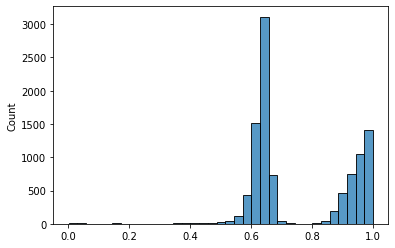

In [58]:
import seaborn as sns
sns.histplot(d)